In [1]:
#@title imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from scipy.stats import linregress

In [2]:
#@title datasetManagement
def load_data(path):
    df = pd.read_csv(path)
    return df

def convert_temperature(df):
    df['temperature'] = df['temperature'].str.replace('C', '').astype(float)
    return df

def calculate_time_metrics(df, fps):
    df['flip_start_time'] = df['start_frame'] / fps
    df['flip_end_time'] = df['end_frame'] / fps
    df['total_duration_seconds'] = df['total_frames'] / fps
    return df

def subset_data(df, t0, t1):
    df_filtered = df[
        (df['flip_start_time'] >= t0) &
        (df['flip_start_time'] <= t1)
    ].copy()
    return df_filtered

def calculate_cumulative_flips(df):
    df_sorted = df.sort_values(by=['experiment_code', 'star_id', 'flip_start_time'])
    df_sorted['cumulative_flip_count'] = df_sorted.groupby(['experiment_code', 'star_id']).cumcount() + 1
    return df_sorted


In [3]:
#@title rawDataPlottingFunctions
def loess_with_ci(x, y, frac=0.3, n_boot=1000, ci=95):
    """
    Compute LOESS fit and bootstrap confidence intervals.

    Parameters:
        x (array): 1D array of x values
        y (array): 1D array of y values
        frac (float): Smoothing parameter for lowess (fraction of points)
        n_boot (int): Number of bootstrap iterations
        ci (float): Confidence interval percentage

    Returns:
        x_fit (array): Sorted x values used for LOESS prediction
        y_fit (array): LOESS-smoothed values corresponding to x_fit
        y_lower (array): Lower CI bound at x_fit
        y_upper (array): Upper CI bound at x_fit
    """
    # Sort data by x to ensure a smooth fit
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # Compute initial LOESS
    loess_result = lowess(y_sorted, x_sorted, frac=frac, return_sorted=True)
    x_fit = loess_result[:, 0]
    y_fit = loess_result[:, 1]

    # Bootstrap to get CI
    boot_preds = []
    n = len(x_sorted)
    for _ in range(n_boot):
        # Resample indices with replacement
        idx = np.random.randint(0, n, n)
        x_boot = x_sorted[idx]
        y_boot = y_sorted[idx]

        # Fit LOESS on bootstrap sample
        boot_loess = lowess(y_boot, x_boot, frac=frac, return_sorted=True)

        # Interpolate predictions at x_fit for consistent comparisons
        # np.interp requires x_boot to be sorted. Ensure it's sorted first.
        boot_x_order = np.argsort(boot_loess[:, 0])
        boot_xs = boot_loess[boot_x_order, 0]
        boot_ys = boot_loess[boot_x_order, 1]

        y_boot_pred = np.interp(x_fit, boot_xs, boot_ys)
        boot_preds.append(y_boot_pred)

    boot_preds = np.array(boot_preds)
    lower_bound = (100 - ci) / 2
    upper_bound = 100 - lower_bound
    y_lower = np.percentile(boot_preds, lower_bound, axis=0)
    y_upper = np.percentile(boot_preds, upper_bound, axis=0)

    return x_fit, y_fit, y_lower, y_upper

def plot_loess_smoothing_with_ci(
    df, t0, t1, plot_dir,
    frac=0.3, n_boot=100, ci=95,
    # Plotting parameters
    figsize=(6,4),
    scatter_alpha=0.3,
    scatter_size=20,
    line_width=2.5,
    ci_alpha=0.2,
    vertical_line_style='--',
    vertical_line_width=2,
    vertical_line_alpha=0.7,
    cmap='Grays',
    grid_linestyle='--',
    grid_linewidth=0.5,
    grid_alpha=0.7,
    xlabel='Time in Experiment (min)',
    ylabel='Flip Duration (sec)',
    title='LOESS-Smoothed Flip Duration by Temperature',
    title_fontsize=12,
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    legend_title='Temperature (°C)',
    legend_title_fontsize=12,
    legend_fontsize=12,
    dpi=300,
    # Text annotations for t0 and t1
    text_offset_x=0.1,   # Horizontal offset from the vertical line
    text_offset_y=0.05,  # Vertical offset as a fraction of y-range
    text_fontsize=12,
    # Colormap range parameters to avoid white lines
    cmap_min=0.4,
    cmap_max=0.9
):
    """
    Plot flip duration as a function of time (in minutes) using LOESS smoothing with bootstrap CIs.
    Vertical lines indicating t0 and t1 are drawn, and annotated directly on the plot.
    The Grays colormap is used, and the range is restricted to avoid too-white lines.

    Parameters:
        df (pd.DataFrame): Dataframe with 'flip_start_time', 'duration_seconds', 'temperature'
        t0 (float): Start cut in minutes
        t1 (float): End cut in minutes
        plot_dir (str): Directory to save the plot
        frac (float): LOESS fraction parameter
        n_boot (int): Number of bootstrap iterations for CI
        ci (float): Confidence interval (e.g., 95 for 95% CI)

        # Plotting parameters:
        figsize (tuple): Size of the figure (width, height)
        scatter_alpha (float): Alpha for scatter points
        scatter_size (int): Size for scatter points
        line_width (float): Line width for LOESS lines
        ci_alpha (float): Alpha for CI fill area
        vertical_line_style (str): Line style for vertical reference lines
        vertical_line_width (float): Line width for vertical reference lines
        vertical_line_alpha (float): Alpha for vertical reference lines
        cmap (str): Colormap name for temperature series
        grid_linestyle (str): Linestyle for grid
        grid_linewidth (float): Line width for grid lines
        grid_alpha (float): Alpha for grid lines
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        title (str): Plot title
        title_fontsize (int): Font size for title
        xlabel_fontsize (int): Font size for x-axis label
        ylabel_fontsize (int): Font size for y-axis label
        legend_title (str): Title for legend
        legend_title_fontsize (int): Font size for legend title
        legend_fontsize (int): Font size for legend items
        dpi (int): Dots per inch for the saved figure
        text_offset_x (float): Horizontal offset for annotation texts relative to the vertical line
        text_offset_y (float): Vertical offset as a fraction of the y-range for annotation texts
        text_fontsize (int): Font size for annotation texts
        cmap_min (float): Minimum value for colormap range
        cmap_max (float): Maximum value for colormap range

    Returns:
        None
    """
    df = df.copy()
    df['temperature'] = df['temperature'].astype(float)
    df['flip_minute'] = df['flip_start_time'] / 60.0

    unique_temps = sorted(df['temperature'].unique())

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    colormap = colormaps.get_cmap(cmap)
    color_values = np.linspace(cmap_min, cmap_max, len(unique_temps))
    colors = colormap(color_values)

    for temp, color in zip(unique_temps, colors):
        temp_data = df[df['temperature'] == temp]
        x = temp_data['flip_minute'].values
        y = temp_data['duration_seconds'].values

        # Compute LOESS and CI
        x_fit, y_fit, y_lower, y_upper = loess_with_ci(x, y, frac=frac, n_boot=n_boot, ci=ci)

        # Plot scatter
        ax.scatter(x, y, color=color, alpha=scatter_alpha, s=scatter_size)

        # Plot LOESS line
        ax.plot(x_fit, y_fit, color=color, linewidth=line_width, label=f"{temp}°C")

        # Plot CI band
        ax.fill_between(x_fit, y_lower, y_upper, color=color, alpha=ci_alpha)

    # Add vertical lines (without legend entries)
    if t0 is not None:
        ax.axvline(x=t0, color='black', linestyle=vertical_line_style,
                   linewidth=vertical_line_width, alpha=vertical_line_alpha)
    if t1 is not None:
        ax.axvline(x=t1, color='black', linestyle=vertical_line_style,
                   linewidth=vertical_line_width, alpha=vertical_line_alpha)

    # Set labels and title
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    ax.set_title(title, fontsize=title_fontsize, loc='left')
    
    # define xticks and labels
    xticks = np.arange(np.floor(df['flip_minute'].min()), np.ceil(df['flip_minute'].max()) + 1, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    
    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out', length=3, width=1, colors='black',
                   bottom=True, left=True)

    # Ensure spines are visible and set their color
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    # Make sure grid lines do not hide ticks
    ax.set_axisbelow(True)

    # Set grid
    ax.grid(True, which='major', linestyle=grid_linestyle, linewidth=grid_linewidth, alpha=grid_alpha)

    # Show legend
    ax.legend(title=legend_title, title_fontsize=legend_title_fontsize, fontsize=legend_fontsize, frameon=False, loc='upper right')

    # Add text annotations for t0 and t1
    y_min, y_max = ax.get_ylim()
    if t0 is not None:
        ax.text(t0 + text_offset_x,
                y_max - text_offset_y*(y_max - y_min),
                f"t0={t0} min", fontsize=text_fontsize, va='top', ha='left')
    if t1 is not None:
        ax.text(t1 + text_offset_x,
                y_max - text_offset_y*(y_max - y_min),
                f"t1={t1} min", fontsize=text_fontsize, va='top', ha='left')

    path_fig = os.path.join(plot_dir, f'loess_smoothing_t0_{t0}_t1_{t1}.png')

    fig.tight_layout()
    fig.savefig(path_fig, dpi=dpi)
    plt.show()
    plt.close(fig)


In [4]:
#@title outlierDetectionAndVisualization
def find_outliers_iqr(df, duration_col='duration_seconds', tails='upper'):
    """
    Identify outliers in the dataset based on IQR method.
    """
    Q1 = df[duration_col].quantile(0.25)
    Q3 = df[duration_col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if tails == 'upper':
        outliers = df[duration_col] > upper_bound
    elif tails == 'lower':
        outliers = df[duration_col] < lower_bound
    elif tails == 'both':  
        outliers = (df[duration_col] < lower_bound) | (df[duration_col] > upper_bound)
    else:
        raise ValueError("Invalid tails parameter. Choose 'upper', 'lower', or 'both'.")
    return outliers

def plot_full_distribution_with_outliers_line_two_yaxes(
    df, flip_time_col='flip_start_time', duration_col='duration_seconds',
    outlier_col='is_outlier', plot_dir='.', dpi=300,
    # Plotting parameters
    figsize=(6,4),
    violin_positions=[-2],
    violin_facecolor='gray',
    violin_edgecolor='black',
    violin_alpha=0.7,
    non_outlier_color='lightgray',
    outlier_color='red',
    scatter_size=10,
    scatter_alpha_non_outlier=0.5,
    scatter_alpha_outlier=0.7,
    scatter_edgecolor='white',
    scatter_linewidth=0.5,
    secondary_line_color='black',
    secondary_line_width=2,
    x_left_limit_offset=-3,
    x_right_limit_offset=0.5,
    xtick_distance=1,
    xtick_outlier_label='Flip Rate',
    num_yticks=5,
    duration_ylabel='Flip Duration (sec)',
    outlier_ylabel = r"Outlier Ratio ($\frac{\text{Outliers}}{\text{Samples}}$)",
    title='Outlier Rate Binned by Minute',
    title_fontsize=12,
    xlabel = r"Time Bins ($t_0 < t \leq t_1$)", 
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    legend_loc='upper left',
    legend_fontsize=10,
    legend_title="Points",
    legend_title_fontsize=10,
    grid_linestyle='--',
    grid_alpha=1
):
    """
    Plot the full distribution of durations as a violin at a specified x-position with points overlaid,
    and a line plot of the ratio of outliers by minute on a separate y-axis.
    The durations are normalized to 0->1 for plotting, but displayed starting at 0 up to dur_range.
    The ratio of outliers axis dynamically adjusts to the maximum ratio found, instead of always going to 1.

    Parameters:
        df (pd.DataFrame): DataFrame with 'flip_start_time', 'duration_seconds', 'is_outlier'.
        flip_time_col (str): Column with flip start times in seconds.
        duration_col (str): Column with the duration data.
        outlier_col (str): Column indicating if a point is an outlier (boolean).
        plot_dir (str): Directory to save the figure.
        dpi (int): Dots per inch for saving the figure.

        # Plotting parameters:
        (See function head for details)
    """
    df = df.copy()
    # Convert flip times to minutes and group by minute
    df['flip_minute'] = df[flip_time_col] / 60.0
    df['minute_floor'] = df['flip_minute'].floordiv(1)

    # Compute counts and outliers per bin
    counts_per_bin = df.groupby('minute_floor')[outlier_col].count()
    outliers_per_bin = df.groupby('minute_floor')[outlier_col].sum()

    # Compute ratio of outliers
    outlier_ratio = outliers_per_bin / counts_per_bin

    # Extract durations and outlier info
    all_durations = df[duration_col].values
    non_outliers = df[~df[outlier_col]]
    outliers_df = df[df[outlier_col]]

    # Compute min/max for durations
    dur_min, dur_max = all_durations.min(), all_durations.max()
    dur_range = dur_max - dur_min if (dur_max - dur_min) != 0 else 1

    # Normalize durations to [0,1]
    norm_all_durations = (all_durations - dur_min) / dur_range
    norm_non_outliers = (non_outliers[duration_col].values - dur_min) / dur_range
    norm_outliers = (outliers_df[duration_col].values - dur_min) / dur_range

    fig, ax = plt.subplots(figsize=figsize)

    # Violin for full distribution (normalized)
    parts = ax.violinplot([norm_all_durations], positions=violin_positions, 
                          showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(violin_facecolor)
        pc.set_edgecolor(violin_edgecolor)
        pc.set_alpha(violin_alpha)
    
    # Scatter non-outliers (normalized)
    ax.scatter(np.full(len(norm_non_outliers), violin_positions[0]), norm_non_outliers,
               color=non_outlier_color, s=scatter_size, alpha=scatter_alpha_non_outlier,
               edgecolors=scatter_edgecolor, linewidths=scatter_linewidth, label='Non-outliers')
    
    # Scatter outliers (normalized)
    ax.scatter(np.full(len(norm_outliers), violin_positions[0]), norm_outliers,
               color=outlier_color, s=scatter_size, alpha=scatter_alpha_outlier,
               edgecolors=scatter_edgecolor, linewidths=scatter_linewidth, label='Outliers')

    # Secondary axis for outlier ratio
    ax2 = ax.twinx()

    if len(outlier_ratio) > 0:
        # Determine max ratio and set y-limits accordingly
        max_ratio = outlier_ratio.max()
        # Add some padding above the max ratio
        y2max = max_ratio * 1.1 if max_ratio > 0 else 1.0
        ax2.set_ylim(-.005, y2max)
        ax2.plot(outlier_ratio.index, outlier_ratio.values, marker='o', color=secondary_line_color, linewidth=secondary_line_width)
        
        # Update ticks based on actual max ratio
        y2tick_vals = np.linspace(0, y2max, num_yticks)
        y2tick_labels = [f"{val:.2f}" for val in y2tick_vals]
        ax2.set_yticks(y2tick_vals)
        ax2.set_yticklabels(y2tick_labels)
    else:
        # If no data, just default to 0->1
        ax2.set_ylim(0, 1)
        y2tick_vals = np.linspace(0, 1, num_yticks)
        y2tick_labels = [f"{val:.2f}" for val in y2tick_vals]
        ax2.set_yticks(y2tick_vals)
        ax2.set_yticklabels(y2tick_labels)

    # Set x-limits
    if len(outlier_ratio) > 0:
        min_minute = int(outlier_ratio.index.min())
        max_minute = int(outlier_ratio.index.max())
    else:
        min_minute = 0
        max_minute = 10
    
    ax.set_xlim(violin_positions[0] + x_left_limit_offset/4, max_minute + x_right_limit_offset)

    # Define x-ticks
    xticks = [violin_positions[0]] + list(range(min_minute, max_minute+1, xtick_distance))
    xlabels = [xtick_outlier_label] + [str(x) for x in xticks[1:]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)

    # Set y-ticks for durations (left axis)
    ytick_vals = np.linspace(0, 1, num_yticks)
    ytick_labels = [f"{(y * dur_range):.0f}" for y in ytick_vals]
    ax.set_yticks(ytick_vals)
    ax.set_yticklabels(ytick_labels)
    ax.set_ylabel(duration_ylabel, fontsize=ylabel_fontsize)

    ax2.set_ylabel(outlier_ylabel, fontsize=ylabel_fontsize)

    # Set title
    ax.set_title(title, fontsize=title_fontsize, loc='left')

    ax.grid(True, linestyle=grid_linestyle, alpha=grid_alpha)
    
    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out', length=3, width=1, colors='black',
                   bottom=True, left=True)

    # Ensure spines are visible and set their color
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)
        
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)


    # Make sure grid lines do not hide ticks
    ax.set_axisbelow(True)
    
    # make vertical line at x=-1
    ax.axvline(x=-1, color='black', linestyle='-', linewidth=1, alpha=0.7)

    path_fig = os.path.join(plot_dir, 'outlier_rate_by_time_bin.png')
    fig.tight_layout()
    fig.savefig(path_fig, dpi=dpi)
    plt.show()
    plt.close(fig)


In [5]:
#@title loadDataset
path_data = os.path.join('..', 'data', 'sea_star_flip_summary.csv')
plot_dir = os.path.join('..', 'plots')
df = load_data(path_data)
df = convert_temperature(df)
df = calculate_time_metrics(df, fps=2)
df = calculate_cumulative_flips(df)
df = df[df['star_id'] != 'p10'] ## no week 1 data
df = df[df['star_id'] != 'i7'] ## no week 1 data

t0 = 1
t1 = None

print('df.columns\n', df.columns)
print('df.head\n', df.head())
print('df.shape\n', df.shape)

df.columns
 Index(['source_file', 'experiment_code', 'run', 'week', 'temperature',
       'star_id', 'date', 'time', 'flip_number', 'start_frame', 'end_frame',
       'duration_frames', 'duration_seconds', 'seconds_from_first_flip_start',
       'total_frames', 'flip_start_time', 'flip_end_time',
       'total_duration_seconds', 'cumulative_flip_count'],
      dtype='object')
df.head
                                          source_file experiment_code run week  \
0  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
1  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
2  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
3  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
4  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   

   temperature star_id        date      time  flip_number  start_frame  \
0         12.0     i11  2023-11-12  14:51:47       

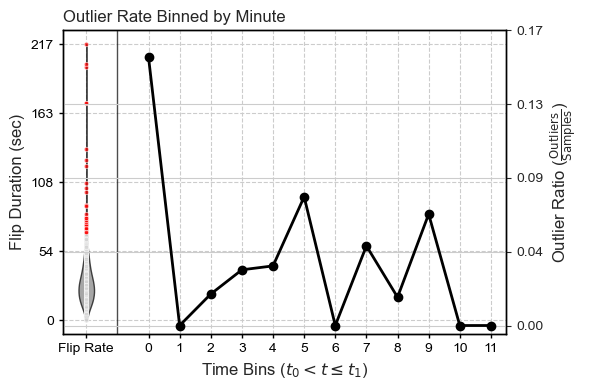

In [6]:
#@title visualizeOutliers
outliers = find_outliers_iqr(df, duration_col='duration_seconds', tails='both')
df['is_outlier'] = outliers
plot_full_distribution_with_outliers_line_two_yaxes(df, plot_dir=plot_dir)

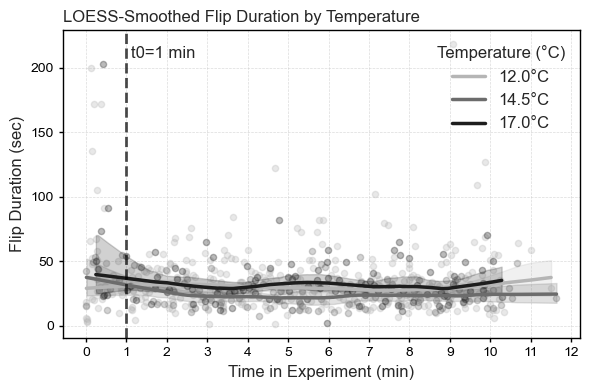

In [7]:
#@title visualizeRaw
plot_loess_smoothing_with_ci(df, t0, t1, plot_dir, frac=0.3, n_boot=100, ci=95)

In [8]:
#@title doesTimeInExperimentPredictRightingDuration
experiment_code_dict = {
    'R1_W1_12C' : 'B_12->14.5_T0',
    'R1_W2_14-5C': 'B_12->14.5_T1',
    'R2_W1_12C': 'A_12->12_T0',
    'R2_W2_12C' : 'A_12->12_T1',
    'R3_W1_12C' : 'C_12->17_T0',
    'R3_W2_17C' : 'C_12->17_T1',
}
experiment_codes_alpha_numeric = [experiment_code_dict[code] for code in df['experiment_code']]
df['experiment_codes_symbols'] = experiment_codes_alpha_numeric

#1) run without dropping the first minute
print('#### with first minute ####')
md_full = smf.mixedlm(
    formula="duration_seconds ~ flip_start_time + C(experiment_codes_symbols) + flip_start_time:C(experiment_codes_symbols)",
    data=df,
    groups=df["star_id"],
)
mdf_full = md_full.fit(method='nm', reml=True)
print(mdf_full.summary())

#2) run with dropping the first minute
print('#### without first minute ####')
md = smf.mixedlm(
    formula="duration_seconds ~ flip_start_time + C(experiment_codes_symbols) + flip_start_time:C(experiment_codes_symbols)",
    data=df[df['flip_start_time'] >= 60],
    groups=df[df['flip_start_time'] >= 60]["star_id"],
)
mdf = md.fit(method='nm', reml=True)
print(mdf.summary())


#### with first minute ####
                                  Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               duration_seconds
No. Observations:                601                   Method:                           REML            
No. Groups:                      21                    Scale:                            430.6948        
Min. group size:                 16                    Log-Likelihood:                   -2699.6760      
Max. group size:                 41                    Converged:                        Yes             
Mean group size:                 28.6                                                                    
---------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------

In [9]:
#@title doesTimeInExperimentPredictRightingDuration_exponential
################################
# 1) WITH FIRST MINUTE
################################
print('#### with first minute (LOG model) ####')

# We drop rows where duration_seconds <= 0, 
# just to be safe (log transform requires positive values).
df_for_log = df[df['duration_seconds'] > 0].copy()

md_full_exp = smf.mixedlm(
    formula=(
        "np.log(duration_seconds) ~ "
        "flip_start_time + "
        "C(experiment_codes_symbols) + "
        "flip_start_time:C(experiment_codes_symbols)"
    ),
    data=df_for_log,
    groups=df_for_log["star_id"],
)
mdf_full_exp = md_full_exp.fit(method='nm', reml=True)
print(mdf_full_exp.summary())

# Compare AIC to your linear model, if desired
print("AIC:", mdf_full_exp.aic, "BIC:", mdf_full_exp.bic)


################################
# 2) WITHOUT FIRST MINUTE
################################
print('\n#### without first minute (LOG model) ####')
df_for_log_60 = df_for_log[df_for_log['flip_start_time'] >= 60].copy()

md_exp = smf.mixedlm(
    formula=(
        "np.log(duration_seconds) ~ "
        "flip_start_time + "
        "C(experiment_codes_symbols) + "
        "flip_start_time:C(experiment_codes_symbols)"
    ),
    data=df_for_log_60,
    groups=df_for_log_60["star_id"],
)
mdf_exp = md_exp.fit(method='nm', reml=True)
print(mdf_exp.summary())

# Compare AIC to your linear model as well
print("AIC:", mdf_exp.aic, "BIC:", mdf_exp.bic)


#### with first minute (LOG model) ####
                                 Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            np.log(duration_seconds)
No. Observations:            601                Method:                        REML                    
No. Groups:                  21                 Scale:                         0.2793                  
Min. group size:             16                 Log-Likelihood:                -538.7419               
Max. group size:             41                 Converged:                     Yes                     
Mean group size:             28.6                                                                      
-------------------------------------------------------------------------------------------------------
                                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------

In [10]:
#@title Manual AIC/BIC Calculation for REML Fits (Not Strictly Recommended)
def compute_reml_aic(result):
    """
    Compute a 'pseudo-AIC' using the REML log-likelihood.
    
    AIC = -2 * REML log-likelihood + 2 * K,
    where K is the total number of estimated parameters
    (including fixed effects, random effects variance params, etc.)
    """
    llf = result.llf            # REML log-likelihood
    k = result.df_modelwc       # Number of parameters (fixed + random)
    return -2.0 * llf + 2.0 * k

def compute_reml_bic(result):
    """
    Compute a 'pseudo-BIC' using the REML log-likelihood.
    
    BIC = -2 * REML log-likelihood + log(n) * K
    """
    llf = result.llf
    k = result.df_modelwc
    n = result.nobs            # total observations
    return -2.0 * llf + np.log(n) * k

# Suppose you've already fit your models with REML=True, method='nm' (and they converged):
#   mdf_full = <your model with first minute included>
#   mdf      = <your model dropping the first minute>

print("=== Manual AIC/BIC for REML Fit: 'with first minute' ===")
pseudo_aic_full = compute_reml_aic(mdf_full)
pseudo_bic_full = compute_reml_bic(mdf_full)
print(f"Pseudo-AIC: {pseudo_aic_full:.3f},  Pseudo-BIC: {pseudo_bic_full:.3f}")

print("\n=== Manual AIC/BIC for REML Fit: 'without first minute' ===")
pseudo_aic = compute_reml_aic(mdf)
pseudo_bic = compute_reml_bic(mdf)
print(f"Pseudo-AIC: {pseudo_aic:.3f},  Pseudo-BIC: {pseudo_bic:.3f}")

print("\n=== Manual AIC/BIC for log(duration_seconds) REML Fit: 'with first minute' ===")
pseudo_aic_full_exp = compute_reml_aic(mdf_full_exp)
pseudo_bic_full_exp = compute_reml_bic(mdf_full_exp)
print(f"Pseudo-AIC: {pseudo_aic_full_exp:.3f},  Pseudo-BIC: {pseudo_bic_full_exp:.3f}")

print("\n=== Manual AIC/BIC for log(duration_seconds) REML Fit: 'without first minute' ===")
pseudo_aic_exp = compute_reml_aic(mdf_exp)
pseudo_bic_exp = compute_reml_bic(mdf_exp)
print(f"Pseudo-AIC: {pseudo_aic_exp:.3f},  Pseudo-BIC: {pseudo_bic_exp:.3f}")

print("""
NOTE:
- These 'Pseudo-AIC'/'Pseudo-BIC' values are from the REML log-likelihood.
- If you change fixed effects, it's not a valid comparison by classical AIC logic.
- For serious model comparison, consider full ML, an LRT on nested random effects,
  or a cross-validation approach.
""")


=== Manual AIC/BIC for REML Fit: 'with first minute' ===
Pseudo-AIC: 5425.352,  Pseudo-BIC: 5482.534

=== Manual AIC/BIC for REML Fit: 'without first minute' ===
Pseudo-AIC: 4667.366,  Pseudo-BIC: 4723.253

=== Manual AIC/BIC for log(duration_seconds) REML Fit: 'with first minute' ===
Pseudo-AIC: 1103.484,  Pseudo-BIC: 1160.666

=== Manual AIC/BIC for log(duration_seconds) REML Fit: 'without first minute' ===
Pseudo-AIC: 933.549,  Pseudo-BIC: 989.436

NOTE:
- These 'Pseudo-AIC'/'Pseudo-BIC' values are from the REML log-likelihood.
- If you change fixed effects, it's not a valid comparison by classical AIC logic.
- For serious model comparison, consider full ML, an LRT on nested random effects,
  or a cross-validation approach.


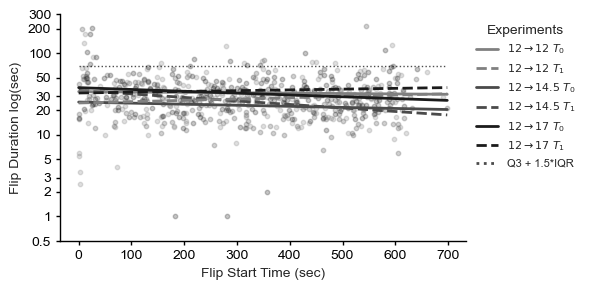

In [11]:
#@title visualizeDurationSecondsVSTimeByExperiment

coefs = mdf_full_exp.params  # pandas Series-like

def predict_duration_pop_level(flip_times, exp_code, coefs, ref='A_12->12_T0'):
    """
    Predict the *population-level* duration (in seconds) at each value in flip_times,
    for the specified experiment_code. Does *not* include per-subject random intercepts.

    Parameters
    ----------
    flip_times : array-like, the X-values to predict at
    exp_code   : str, e.g. 'B_12->14.5_T0'
    coefs      : model coefficients from mdf_full_exp.params
    ref        : str, the reference category in your factor-coded variable.
    
    Returns
    -------
    predicted_duration : np.ndarray of shape == flip_times.shape
    """
    # Baseline intercept and slope
    intercept = coefs["Intercept"]
    slope     = coefs["flip_start_time"]
    
    # If the experiment_code is not the reference level, 
    # add the intercept offset and slope offset if present
    offset_key = f"C(experiment_codes_symbols)[T.{exp_code}]"
    slope_key  = f"flip_start_time:C(experiment_codes_symbols)[T.{exp_code}]"
    
    if offset_key in coefs:
        intercept += coefs[offset_key]
    if slope_key in coefs:
        slope += coefs[slope_key]

    # linear predictor on log scale
    log_pred = intercept + slope * flip_times
    return np.exp(log_pred)  # exponentiate to get predictions on original scale

xvals = np.linspace(0, df['flip_start_time'].max(), 300)  # or pick your own range

experiment_code_dict = {
    'R1_W1_12C' : 'B_12->14.5_T0',
    'R1_W2_14-5C': 'B_12->14.5_T1',
    'R2_W1_12C': 'A_12->12_T0',
    'R2_W2_12C' : 'A_12->12_T1',
    'R3_W1_12C' : 'C_12->17_T0',
    'R3_W2_17C' : 'C_12->17_T1',
}
experiment_code_colors = { ## gray scale from light to dark
    'A_12->12_T0': '#808080',
    'A_12->12_T1': '#808080',
    'B_12->14.5_T0': '#4A4A4A',
    'B_12->14.5_T1': '#4A4A4A',
    'C_12->17_T0': '#1B1B1B',
    'C_12->17_T1': '#1B1B1B',
}
experiment_code_linestyle = {
    'A_12->12_T0': '--',
    'A_12->12_T1': '-',
    'B_12->14.5_T0': '--',
    'B_12->14.5_T1': '-',
    'C_12->17_T0': '--',
    'C_12->17_T1': '-',
}
custom_lines = [
    plt.Line2D([0], [0], color=experiment_code_colors['A_12->12_T0'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['A_12->12_T1'], lw=2, linestyle='--'),
    plt.Line2D([0], [0], color=experiment_code_colors['B_12->14.5_T0'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['B_12->14.5_T1'], lw=2, linestyle='--'),
    plt.Line2D([0], [0], color=experiment_code_colors['C_12->17_T0'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['C_12->17_T1'], lw=2, linestyle='--'),
]
custom_labels = [
    r'$12 \to 12$ $T_0$',
    r'$12 \to 12$ $T_1$',
    r'$12 \to 14.5$ $T_0$',
    r'$12 \to 14.5$ $T_1$',
    r'$12 \to 17$ $T_0$',
    r'$12 \to 17$ $T_1$',
]

fig, ax = plt.subplots(1,1,figsize=(6,3))

# upper_limit_outier_line = Q3 + 1.5 * IQR
upper_limit_outier_line = df['duration_seconds'].quantile(0.75) + 1.5 * (df['duration_seconds'].quantile(0.75) - df['duration_seconds'].quantile(0.25))
xs = [0, df['flip_start_time'].max()]
ys = [upper_limit_outier_line, upper_limit_outier_line]
ax.plot(xs, ys, color='black', linestyle=':', linewidth=1, alpha=0.7)

custom_labels.append('Q3 + 1.5*IQR')
custom_lines.append(plt.Line2D([0], [0], color='black', lw=2, linestyle=':', alpha=0.7))

time_bins = [(i, i+60) for i in range(0, 700, 60)]
outliers_rate_dict = {experiment_code: [] for experiment_code in experiment_code_dict.values()}
for i, experiment_code in enumerate(experiment_code_dict.keys()):
    tmp = df[df['experiment_code'] == experiment_code]
    color = experiment_code_colors[experiment_code_dict[experiment_code]]
    
    x = tmp['flip_start_time']
    y = tmp['duration_seconds']
    
    ax.scatter(x, y, color=color, alpha=0.25, label=experiment_code_dict[experiment_code], s=10)
    
    yhat = predict_duration_pop_level(xvals, experiment_code_dict[experiment_code], coefs)
    ax.plot(xvals, yhat, color=color, linewidth=2, linestyle=experiment_code_linestyle[experiment_code_dict[experiment_code]])
    
    ## for each time bin, calculate the outlier rate
    ## rate is calculated by the num_outliers_in_bin / num_points_in_bin
    outliers = tmp['is_outlier']
    for t0, t1 in time_bins:
        num_points_in_bin = tmp[(tmp['flip_start_time'] >= t0) & (tmp['flip_start_time'] < t1)].shape[0]
        num_outliers_in_bin = tmp[(tmp['flip_start_time'] >= t0) & (tmp['flip_start_time'] < t1) & (tmp['is_outlier'])].shape[0]
        rate = num_outliers_in_bin / num_points_in_bin if num_points_in_bin > 0 else 0
        outliers_rate_dict[experiment_code_dict[experiment_code]].append(rate)

ax.legend(custom_lines, custom_labels, bbox_to_anchor=(1, 1), loc='upper left', fontsize=8, title='Experiments', frameon=False)

# Turn on a grid
ax.grid(False)#, linestyle='--', alpha=0.5, zorder=0)
# Force tick marks to appear and be visible
ax.tick_params(axis='both', which='major', direction='out',
               length=3, width=1, colors='black', bottom=True, left=True)
# Make spines visible and in black
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
    spine.set_alpha(1)
## turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yscale('log')
ax.set_ylabel('Flip Duration log(sec)')
ax.set_xlabel('Flip Start Time (sec)')

yticks = [.5, 1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300]
yticklabels = [str(y) for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

name_fig = 'duration_seconds_vs_time_by_experiment.png'
path_fig = os.path.join(plot_dir, name_fig)

fig.tight_layout()

plt.savefig(path_fig, dpi=300)

plt.show()
plt.close()

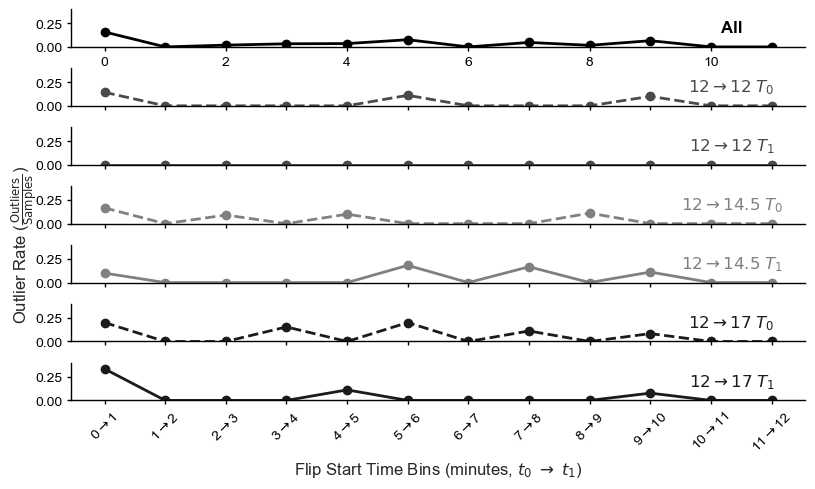

In [12]:
#@title visualizeOutlierRateVSTimeByExperimentAndTimeBin

fig, axs = plt.subplots(7,1,figsize=(8,5))

## plot all at the top
color = 'black'
ax=axs[0]
ax.set_ylim(0,0.4)

rate_outliers_by_bin = []
for t0, t1 in time_bins:
    num_points_in_bin = df[(df['flip_start_time'] >= t0) & (df['flip_start_time'] < t1)].shape[0]
    num_outliers_in_bin = df[(df['flip_start_time'] >= t0) & (df['flip_start_time'] < t1) & (df['is_outlier'])].shape[0]
    rate = num_outliers_in_bin / num_points_in_bin if num_points_in_bin > 0 else 0
    rate_outliers_by_bin.append(rate)
    
xs = [i for i in range(len(time_bins))]
ys = rate_outliers_by_bin
ax.plot(xs, ys, color=color, marker='o', linewidth=2, label='All', linestyle='-')

ax.text(0.9, 0.5, 'All', fontsize=12, ha='center', va='center', 
            transform=ax.transAxes, color=color, fontweight='bold')

# Turn on a grid
ax.grid(False)#, linestyle='--', alpha=0.5, zorder=0)
# Force tick marks to appear and be visible
ax.tick_params(axis='both', which='major', direction='out',
               length=3, width=1, colors='black', bottom=True, left=True)
# Make spines visible and in black
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
    spine.set_alpha(1)
## turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for n, experiment_code in enumerate(outliers_rate_dict.keys()):
    ax = axs[n+1]
    color = experiment_code_colors[experiment_code]
    xs = [i for i in range(len(outliers_rate_dict[experiment_code]))]
    ys = outliers_rate_dict[experiment_code]
    ax.plot(xs, ys, color=color, marker='o', 
            linewidth=2, 
            label=experiment_code, 
            linestyle=experiment_code_linestyle[experiment_code])
    
    # Turn on a grid
    ax.grid(False)#, linestyle='--', alpha=0.5, zorder=0)
    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out',
                   length=3, width=1, colors='black', bottom=True, left=True)
    # Make spines visible and in black
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)
    ## turn off top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    title = custom_labels[n]
    ax.text(0.9, 0.5, title, fontsize=12, ha='center', va='center', 
            transform=ax.transAxes, color=color, fontweight='bold')
    
    ax.set_ylim(0,0.4)

    xticks = [i for i in range(len(time_bins))]
    xticklabels = [str(int(t0/60))+r'$\to$'+str(int(t1/60)) for t0, t1 in time_bins]
    ax.set_xticks(xticks)
    if n == 5:
        ax.set_xticklabels(xticklabels, rotation=45)
        ax.set_xlabel(r'Flip Start Time Bins (minutes, $t_0$ $\to$ $t_1$)', fontsize=12)
    else:
        ax.set_xticklabels([])

## add super ylabel
fig.text(-0.0125, 0.5, r'Outlier Rate ($\frac{\text{Outliers}}{\text{Samples}}$)', va='center', rotation='vertical', fontsize=12)

fig.tight_layout(h_pad=0)

name_fig = 'outlier_rate_vs_time_by_experiment_and_time_bin.png'
path_fig = os.path.join(plot_dir, name_fig)

fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show()
plt.close()


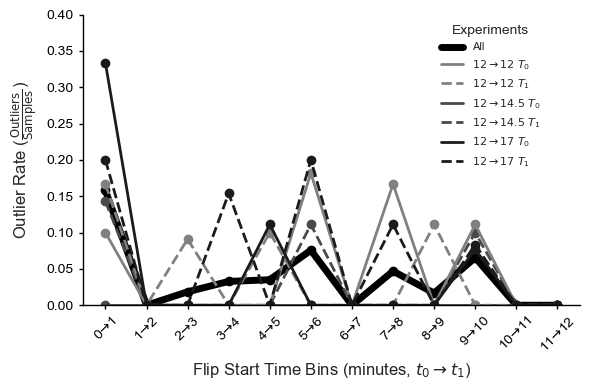

In [13]:
#@title visualizeOutlierRateVSTimeByExperimentAndTimeBin (single-axes version)
fig, ax = plt.subplots(figsize=(6,4))

# 1) Plot "All" line
color = 'black'
rate_outliers_by_bin = []
for t0, t1 in time_bins:
    num_points_in_bin = df[(df['flip_start_time'] >= t0) & (df['flip_start_time'] < t1)].shape[0]
    num_outliers_in_bin = df[(df['flip_start_time'] >= t0) & (df['flip_start_time'] < t1) & (df['is_outlier'])].shape[0]
    rate = num_outliers_in_bin / num_points_in_bin if num_points_in_bin > 0 else 0
    rate_outliers_by_bin.append(rate)

xs = range(len(time_bins))
ys = rate_outliers_by_bin

ax.plot(xs, ys, color=color, marker='o', linewidth=5, linestyle='-', 
        label='All')

# 2) Plot each experiment's line
#    outliers_rate_dict is a dict keyed by e.g. 'A_12->12_T0', etc., 
#    with lists of outlier rates per time bin.
for n, exp_code in enumerate(outliers_rate_dict.keys()):
    color = experiment_code_colors[exp_code]
    xs_exp = range(len(outliers_rate_dict[exp_code]))
    ys_exp = outliers_rate_dict[exp_code]

    # Use a matching label from your custom_labels, or just use exp_code
    # if you prefer. For a 1-to-1 match by index, be sure the dict iteration 
    # matches the order in custom_labels. If not, you'll need a map.
    # Example below assumes outliers_rate_dict.keys() is in the same order as custom_labels.
    # If you need a robust approach, you may want a dictionary: 
    #   exp_label_map = {'A_12->12_T0': '12->12 T0', ...} 
    # and do label=exp_label_map[exp_code].
    
    label_str = f"{custom_labels[n]}"  # or experiment_code
    ax.plot(xs_exp, ys_exp, 
            color=color, 
            marker='o', 
            linewidth=2, 
            linestyle=experiment_code_linestyle[exp_code],
            label=label_str)

# 3) Format the x-axis ticks
ax.set_ylim(0, 0.4)
xticks = list(range(len(time_bins)))
xticklabels = [
    f"{int(t0/60)}$\u2192${int(t1/60)}"
    for (t0, t1) in time_bins
]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45)

# 4) Axis labels, etc.
ax.set_xlabel(r"Flip Start Time Bins (minutes, $t_0 \to t_1$)", fontsize=12)
ax.set_ylabel(r"Outlier Rate ($\frac{\text{Outliers}}{\text{Samples}}$)", fontsize=12)

# 5) Legend
custom_lines = [
    plt.Line2D([0], [0], color='black', lw=5, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['A_12->12_T0'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['A_12->12_T1'], lw=2, linestyle='--'),
    plt.Line2D([0], [0], color=experiment_code_colors['B_12->14.5_T0'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['B_12->14.5_T1'], lw=2, linestyle='--'),
    plt.Line2D([0], [0], color=experiment_code_colors['C_12->17_T0'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=experiment_code_colors['C_12->17_T1'], lw=2, linestyle='--'),
]
custom_labels = [
    "All",
    r"$12 \to 12$ $T_0$",
    r"$12 \to 12$ $T_1$",
    r"$12 \to 14.5$ $T_0$",
    r"$12 \to 14.5$ $T_1$",
    r"$12 \to 17$ $T_0$",
    r"$12 \to 17$ $T_1$",
]

ax.legend(custom_lines, custom_labels,
          bbox_to_anchor=(.7, 1), loc='upper left', fontsize=8, title='Experiments', frameon=False)

# 6) Grid & spine formatting
ax.grid(False)
ax.tick_params(axis='both', which='major', direction='out',
               length=3, width=1, colors='black', bottom=True, left=True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
    spine.set_alpha(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

name_fig = 'outlier_rate_vs_time_by_experiment_and_time_bin_single_axes.png'
path_fig = os.path.join(plot_dir, name_fig)
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show()
plt.close()


In [14]:
#@title diffOfdiffsAnalysisFunctions
"""
Holds all the helper functions needed to run the difference-in-differences (DiD)
analysis. This cell can be placed at the bottom of the notebook and uses any
imports or supporting functions (statsmodels, pandas, etc.) that might already
exist above.

Key Functions Provided:
    1) label_temp_condition(df): 
         - Assigns each star to 'A','B','C' based on the star’s final temperature 
           (week 2).
         - Returns a modified copy of df with a new column 'TempCondition'.
    2) convert_week_to_timepoint(df): 
         - Maps 'W1' -> 1 and 'W2' -> 2 in a new column 'Timepoint'.
    3) run_diff_of_diffs_mixedlm(df, outcome_col='FlipDuration'):
         - Runs a mixed-effects difference-in-differences model using statsmodels.
         - Formula: outcome ~ C(TempCondition) + C(Timepoint) + C(TempCondition):C(Timepoint)
         - Random intercept for star_id.
         - Returns the fitted model object.
"""

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def label_temp_condition(df, star_id_col='star_id', week_col='week',
                         temperature_col='temperature'):
    """
    Assign each star to 'A', 'B', or 'C' based on the star's final (week 2) temperature.
    - A: final_temp == 12
    - B: final_temp == 14.5
    - C: final_temp == 17

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe containing columns for star_id, week, and temperature.
    star_id_col : str
        Column name identifying each star.
    week_col : str
        Column name that denotes the 'week' (e.g., 'W1', 'W2').
    temperature_col : str
        Column name that denotes the temperature (float).

    Returns
    -------
    df_merged : pd.DataFrame
        A copy of the dataframe with a new column 'TempCondition' indicating
        the final group A/B/C for each star.
    """
    # Step 1: Extract each star's final (Week 2) temperature
    df_w2 = df[df[week_col] == 'W2'].groupby(star_id_col)[temperature_col].first()
    df_w2 = df_w2.rename('final_temp').to_frame().reset_index()

    # Step 2: Define a function to map numeric final_temp -> A/B/C
    def map_final_temp_to_condition(t):
        if np.isclose(t, 12.0):
            return 'A'
        elif np.isclose(t, 14.5):
            return 'B'
        elif np.isclose(t, 17.0):
            return 'C'
        else:
            return np.nan  # or raise an error

    df_w2['TempCondition'] = df_w2['final_temp'].apply(map_final_temp_to_condition)

    # Step 3: Merge that info back onto the original dataframe
    df_merged = pd.merge(df.copy(), df_w2[[star_id_col, 'TempCondition']],
                         on=star_id_col, how='left')
    
    return df_merged


def convert_week_to_timepoint(df, week_col='week', new_col='Timepoint'):
    """
    Maps 'W1' -> 1 and 'W2' -> 2 in a new column (default 'Timepoint').

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a 'week' column that has values 'W1' or 'W2'.
    week_col : str
        Name of the existing week column.
    new_col : str
        Name of the new column to store numeric timepoint.

    Returns
    -------
    df : pd.DataFrame
        Modified copy of the dataframe with the new numeric timepoint column.
    """
    df = df.copy()
    mapping = {'W1': 1, 'W2': 2}
    df[new_col] = df[week_col].map(mapping)
    return df


def run_diff_of_diffs_mixedlm(df, outcome_col='FlipDuration',
                              star_id_col='star_id',
                              tempcond_col='TempCondition',
                              timepoint_col='Timepoint',
                              reml=True):
    """
    Runs the difference-in-differences analysis as a linear mixed-effects model.

    Model formula:
        outcome ~ C(TempCondition) + C(Timepoint) + C(TempCondition):C(Timepoint)
    Random intercept: star_id

    Example interpretation of coefficients:
    --------------------------------------
    - Intercept:        baseline (A group, Timepoint=1)
    - C(TempCondition)[T.B]: difference of B vs. A at baseline
    - C(TempCondition)[T.C]: difference of C vs. A at baseline
    - C(Timepoint)[T.2]: difference from Timepoint=1 to Timepoint=2 for group A
    - C(TempCondition)[T.B]:C(Timepoint)[T.2]: DiD effect for group B vs. A
    - C(TempCondition)[T.C]:C(Timepoint)[T.2]: DiD effect for group C vs. A

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for outcome, star ID, temperature condition, timepoint.
    outcome_col : str
        Name of the column with the numeric outcome (e.g., flip duration).
    star_id_col : str
        Name of the column identifying each star.
    tempcond_col : str
        Name of the column indicating the final temperature condition in {A,B,C}.
    timepoint_col : str
        Name of the column indicating timepoint in {1,2}.

    Returns
    -------
    result : statsmodels regression result
        The fitted MixedLM model object from statsmodels.
    """
    df = df.copy()

    # Ensure these columns are categorical (if needed)
    df[tempcond_col] = pd.Categorical(df[tempcond_col], categories=['A','B','C'], ordered=False)
    df[timepoint_col] = pd.Categorical(df[timepoint_col], categories=[1,2], ordered=False)

    # Build the formula
    formula = f"""
    {outcome_col} ~ C({tempcond_col}) + C({timepoint_col}) + C({tempcond_col}):C({timepoint_col})
    """.strip()

    # Fit the mixed-effects model
    md = smf.mixedlm(formula, data=df, groups=df[star_id_col])
    result = md.fit(method='nm', reml=reml)
    return result


In [15]:
#@title diffOfdiffResultVisualizationFunctions
"""
Holds one or more functions for visualizing and reporting the results of the
difference-in-differences (DiD) analysis. This cell can be placed at the bottom
of the notebook after the analysis functions.

Key Functions Provided:
    1) print_diff_of_diffs_summary(result):
         - Prints a summary of the fitted DiD model from statsmodels.
         - Optionally, can extract and interpret the key coefficients.
    2) plot_diff_in_diff_estimates(df, result, outcome_col='FlipDuration', 
                                   star_id_col='star_id'):
         - (Optional) Provides a conceptual "difference-in-differences style" plot.
           Aggregates or calculates means by group & timepoint, then plots them.
           Overlays the model’s predicted lines, if desired.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def print_diff_of_diffs_summary(result):
    """
    Prints the textual summary of the fitted statsmodels MixedLM or OLS model result.
    Then provides a custom interpretation referencing the actual temperature conditions.
    """

    print("=== Difference-in-Differences Model Summary ===")
    print(result.summary())

    # Custom interpretation block:
    print("\nInterpreting key coefficients (with final temperature groups):")
    print("---------------------------------------------------------------")
    print("  • Intercept:")
    print("      => Baseline (12->12) at Timepoint=1.\n")
    print("  • C(TempCondition)[T.B]:")
    print("      => Baseline difference at Timepoint=1 for 12->14.5 vs. 12->12.\n")
    print("  • C(TempCondition)[T.C]:")
    print("      => Baseline difference at Timepoint=1 for 12->17 vs. 12->12.\n")
    print("  • C(Timepoint)[T.2]:")
    print("      => Difference from Timepoint=1 to Timepoint=2 for 12->12.\n")
    print("  • C(TempCondition)[T.B]:C(Timepoint)[T.2]:")
    print("      => Extra change from T1->T2 (relative to 12->12) for 12->14.5.\n")
    print("  • C(TempCondition)[T.C]:C(Timepoint)[T.2]:")
    print("      => Extra change from T1->T2 (relative to 12->12) for 12->17.\n")

    print("Interpretation logic:\n"
          "--------------------------------------------\n"
          "• If C(TempCondition)[T.B]:C(Timepoint)[T.2] is significantly > 0,\n"
          "    => The 12->14.5 group’s change from T1->T2 is that many units\n"
          "       larger than the 12->12 group’s.\n"
          "• If C(TempCondition)[T.C]:C(Timepoint)[T.2] is significantly > 0,\n"
          "    => The 12->17 group’s change from T1->T2 is that many units\n"
          "       larger than the 12->12 group’s.\n")


def plot_diff_in_diff_estimates(df, 
                                plot_dir,
                                result=None,  
                                outcome_col='duration_seconds',
                                timepoint_col='Timepoint',
                                tempcond_col='TempCondition',
                                star_id_col='star_id',  # Not used here, included for API parity
                                figsize=(5,3)):
    """
    Creates a difference-in-differences style plot *but* with the visual style 
    of raw-data + boxplots + group-means + arrows (as in plot_diff_in_diff_estimates_ols).

    Steps:
      1. Compute group means per (TempCondition, Timepoint).
      2. Plot raw data (with jitter) and overlay boxplots.
      3. Plot star markers for T1/T2 group means, plus an arrow from T1 to T2.
      4. Relabel x-axis with '12 -> 12', '12 -> 14.5', '12 -> 17', matching final TempCondition.
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Aggregate to get the mean outcome per (TempCondition, Timepoint).
    agg_df = df.groupby([tempcond_col, timepoint_col], as_index=False)[outcome_col].mean()

    # 2) If Timepoint is categorical, convert to numeric for pivoting
    if agg_df[timepoint_col].dtype.name == 'category':
        agg_df[timepoint_col] = agg_df[timepoint_col].cat.codes + 1  # => 1 or 2

    # 3) Pivot to get T1/T2 columns
    pivoted = agg_df.pivot(index=tempcond_col, columns=timepoint_col, values=outcome_col)
    pivoted.columns = [f"T{col}" for col in pivoted.columns]  # rename numeric col -> T1/T2

    # 4) Prepare the figure
    fig, ax = plt.subplots(figsize=figsize)

    # We'll collect each condition: e.g. ['A','B','C']
    conditions = pivoted.index.tolist()
    x_vals = np.arange(len(conditions))  # e.g. [0,1,2]

    ############################################################################
    # Plot raw data + boxplots for T1 vs T2 in each condition
    ############################################################################
    for tempcond in df[tempcond_col].unique():
        for timepoint in df[timepoint_col].unique():
            df_temp = df[(df[tempcond_col] == tempcond) & (df[timepoint_col] == timepoint)]
            # identify the x-position for the condition
            x_val = x_vals[conditions.index(tempcond)]
            # shift left or right depending on timepoint
            if timepoint == 1:
                x_val_shift = x_val - 0.2
            elif timepoint == 2:
                x_val_shift = x_val + 0.2
            else:
                x_val_shift = x_val  # if there's some unexpected timepoint

            # raw y-values
            y_vals = df_temp[outcome_col]

            # jitter the points horizontally so they don't overlap
            x_jittered = x_val_shift + (np.random.rand(len(y_vals)) - 0.5) * 0.2

            # scatter the raw data
            ax.scatter(x_jittered, y_vals, s=2, color='black', alpha=0.25, zorder=1)

            # boxplot overlay
            median_props = dict(color='black', linewidth=1.5)
            ax.boxplot(y_vals, 
                       positions=[x_val_shift],
                       patch_artist=False,   # no filled boxes
                       widths=0.1, 
                       showfliers=False,
                       zorder=2,
                       medianprops=median_props)

    ############################################################################
    # Plot group means with star markers & connect them with arrows
    ############################################################################
    # Pull out T1 and T2 means from pivoted
    t1vals = [pivoted.loc[cond, "T1"] if "T1" in pivoted.columns else np.nan
              for cond in conditions]
    t2vals = [pivoted.loc[cond, "T2"] if "T2" in pivoted.columns else np.nan
              for cond in conditions]

    # Star markers for T1 (blue) & T2 (red)
    ax.scatter(x_vals - 0.2, t1vals, 
               color='#1E88E5', label='12°C Baseline', alpha=1, zorder=5, marker="*", s=100)
    ax.scatter(x_vals + 0.2, t2vals, 
               color='#D82015', label='Test', alpha=1, zorder=5, marker="*", s=100)

    # Draw an arrow from T1 -> T2 for each condition
    for i, cond in enumerate(conditions):
        y1, y2 = t1vals[i], t2vals[i]
        # small offset for a nicer arrow angle
        ax.annotate(
            '', 
            xy=(x_vals[i] + 0.175, y2),   # arrow head
            xytext=(x_vals[i] - 0.15, y1),   # arrow tail
            arrowprops=dict(arrowstyle='->', color='#424242', lw=1.5),
            zorder=4
        )

    ############################################################################
    # Customize x-ticks, grid, spines, labels
    ############################################################################
    # Replace the x-tick labels: A->12->12, B->12->14.5, C->12->17
    label_map = {
        'A': r'$12 \to 12$',
        'B': r'$12 \to 14.5$',
        'C': r'$12 \to 17$',
    }
    new_labels = [label_map.get(cond, cond) for cond in conditions]
    ax.set_xticks(x_vals)
    ax.set_xticklabels(new_labels, rotation=0)
    ax.set_xlabel('Temperature (°C) treatments', fontsize=12)

    ax.set_ylabel('Righting Time (sec)', fontsize=12)
   
    # Turn on a grid
    ax.grid(False)#, linestyle='--', alpha=0.5, zorder=0)

    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out',
                   length=3, width=1, colors='black', bottom=True, left=True)

    # Make spines visible and in black
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)
        
    ## turn off top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ############################################################################
    # Legend
    ############################################################################
    handles, labels = ax.get_legend_handles_labels()
    # Use a dict to drop duplicates
    unique_legend = dict(zip(labels, handles))
    ax.legend(unique_legend.values(), unique_legend.keys(), 
              frameon=False, loc='best', title='Averages', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    name_fig = 'diff_in_diff_estimates.png'
    path_fig = os.path.join(plot_dir, name_fig)
    fig.savefig(path_fig, dpi=300)




#########################
###### reml=True #######
#########################
=== Difference-in-Differences Model Summary ===
                       Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        duration_seconds
No. Observations:         601            Method:                    ML              
No. Groups:               21             Scale:                     434.2831        
Min. group size:          16             Log-Likelihood:            -2698.0338      
Max. group size:          41             Converged:                 Yes             
Mean group size:          28.6                                                      
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                34.484  

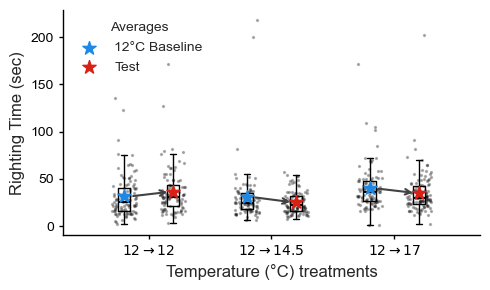

In [16]:
#@title diffOfdiffsAnalysis
"""
Finally, this cell will RUN the analysis and produce outputs,
utilizing the functions from the two cells above.

Process Overview:
1. Load or have your dataframe 'df' in memory with columns:
    ['star_id','week','temperature','FlipDuration', ...]
2. Label each star with final 'TempCondition' => A/B/C
3. Convert 'week' to a numeric 'Timepoint' => 1/2
4. Potentially remove outliers or do any data cleaning
5. Run the difference-in-differences model
6. Print / visualize results
"""

# Example usage code
# NOTE: Adjust paths, column names, or function calls as needed to fit your dataset.

# 1) Create a copy of your DataFrame so we don't mutate the original
df_for_did = df.copy()

# 2) Label the final temperature condition (A/B/C)
df_for_did = label_temp_condition(
    df_for_did,
    star_id_col='star_id',
    week_col='week',
    temperature_col='temperature'
)

# 3) Convert 'week' to numeric 'Timepoint' => 1 or 2
df_for_did = convert_week_to_timepoint(df_for_did, week_col='week', new_col='Timepoint')

# 4) Drop first minute
#df_for_did = df_for_did[df_for_did['flip_start_time'] >= 60]

# 5) Run the difference-in-differences model 
#    using duration_seconds as the dependent variable
#    reml = False

print('#########################')
print('###### reml=True #######')
print('#########################')

result = run_diff_of_diffs_mixedlm(
    df_for_did,
    outcome_col='duration_seconds',  # Use the actual column name from your df
    star_id_col='star_id',
    tempcond_col='TempCondition',
    timepoint_col='Timepoint',
    reml=False,
)

# 6) Print textual summary
print_diff_of_diffs_summary(result)


# 7) run post hoc
# Construct the contrast matrix as a row vector for the single contrast
# The contrast we want to test is [0, 0, 0, 0, 1, -1]
# This corresponds to testing the difference between the two interaction terms
contrast_matrix = np.array([[0, 0, 0, 0, 1, -1]])  # Adjusted to be a 2D array (row vector)

# Perform the t-test using the contrast
t_test_result = result.t_test(contrast_matrix)

# Print the t-test result
print("\nPost Hoc t-test (12->14.5 DiD vs. 12->17 DiD):\n")
print(t_test_result)

# 8) (Optional) Visualize means by condition & timepoint
plot_diff_in_diff_estimates(
    df_for_did,
    plot_dir,
    result,
    outcome_col='duration_seconds',
    timepoint_col='Timepoint',
    tempcond_col='TempCondition',
    star_id_col='star_id'
)

In [17]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                    MixedLM        Dependent Variable:        duration_seconds
No. Observations:         601            Method:                    ML              
No. Groups:               21             Scale:                     434.2831        
Min. group size:          16             Log-Likelihood:            -2698.0338      
Max. group size:          41             Converged:                 Yes             
Mean group size:          28.6                                                      
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                34.484    4.159  8.291 0.000  26.333 42.636
C(TempCondition)[T.B]                    -3.450    6.085 -0.567 0.571 -15.377  8.477
C(TempCondition)[T.C]                     6.674    5.733  1.164 0.244  -4.563 17.910
C(Timepoint)[T.2]                         4.502    3.030  1.486 0.137  -1.437 10.440
C(TempCondition)[T.B]:C(Timepoint)[T.2] -10.335    4.257 -2.428 0.015 -18.678 -1.992
C(TempCondition)[T.C]:C(Timepoint)[T.2]  -8.756    4.191 -2.089 0.037 -16.970 -0.543
Group Var                                89.553    1.654                            
====================================================================================

"""